In [30]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Union, Tuple, Iterable, Optional
from tqdm import tqdm

In [3]:

@dataclass
class Disease:
    beta: float
    gamma: float
    delta: float


In [35]:

class Community:
    def __init__(self, N: int = 10**6, businessmen_frac: float = 0.01, p_business: float = 0.5, business_mixing:float = 0.5, stochastic: bool = True, I0:int = 0):
        """businessmen_frac is the fraction of the population that is in the businessmen class of people who travel all the time
        p_business is the fraction of people who travel who are from the business class
        business_mixing is a parameter which detemines how much businessmen interact with the rest of society: the effective beta for interactions between business and non business people is beta * business_integration
        """
        self.N = {'normal': int(N * (1 - businessmen_frac)),
                  'business': int(N * businessmen_frac)}
        self.businessmen_frac = businessmen_frac
        self.p_business = p_business
        self.business_mixing = business_mixing
        self.stochastic = stochastic
        self.I0 = I0
        self.reset_parameters(I0)
    
    def reset_parameters(self, I: Union[int,float] = 0):
        if self.stochastic:
            assert isinstance(I, int)
            I_n = [np.random.binomial(I, 1-self.businessmen_frac)]
        else:
            I_n = [I * (1-self.businessmen_frac)] 
        I_b = [I - I_n[0]]
        self.data = {}
        self.data['I'] = {'normal': I_n, 'business': I_b}
        self.data['S'] = {'normal': [self.N['normal'] - I_n[0]], 'business': [self.N['business'] - I_b[0]]}
        self.data['E'] = {'normal': [0], 'business': [0]}
        self.data['R'] = {'normal': [0], 'business': [0]}
    
    def simulate(self, time_interval:float, epidemic_time:float, disease:Disease):
        p_recovery = 1 - np.exp( - time_interval * disease.gamma)
        p_infectious = 1 - np.exp( - time_interval * disease.delta)
        timesteps = int(epidemic_time // time_interval)
        self.times = np.linspace(0, epidemic_time, timesteps+1)
        for _ in range(timesteps):
            self.internal_spread(disease.beta,
                                 time_interval,
                                 p_infectious,
                                 p_recovery)

    def internal_spread(self,
                        beta:float,
                        time_interval: float,
                        p_infectious: float,
                        p_recovery: float):
        new_S = {}
        new_E = {}
        new_I = {}
        new_R = {}

        #Mixing between non_businessmen and businessmen separately
        for group in ['normal', 'business']:
            exposure_rate = beta * self.data['I'][group][-1] / self.N[group]
            p_exposure = 1 - np.exp(- time_interval * exposure_rate)
            n_exposed = np.random.binomial(self.data['S'][group][-1], p_exposure)
            n_infectious = np.random.binomial(self.data['E'][group][-1], p_infectious)
            n_recovered = np.random.binomial(self.data['I'][group][-1], p_recovery)
            new_S[group] = self.data['S'][group][-1] - n_exposed
            new_E[group] = self.data['E'][group][-1] + n_exposed - n_infectious
            new_I[group] = self.data['I'][group][-1] + n_infectious - n_recovered
            new_R[group] = self.data['R'][group][-1] + n_recovered
        
        #Mixing between businessmen and nonbusinessmen
        groups = ['normal', 'business']
        for i, group in enumerate(groups):
            exposure_rate = beta * new_I[groups[not i]] / (self.N[groups[0]] + self.N[groups[1]])
            p_exposure = 1 - np.exp(- time_interval * exposure_rate)
            n_exposed = np.random.binomial(new_S[group], p_exposure)
            new_S[group] -= n_exposed
            new_E[group] += n_exposed

            self.data['S'][group].append(new_S[group])
            self.data['E'][group].append(new_E[group])
            self.data['I'][group].append(new_I[group])
            self.data['R'][group].append(new_R[group])
        
    def select_travellers(self, mixnumber: int):
        all_travellers = {'business': np.random.binomial(mixnumber, self.p_business)}
        all_travellers['normal'] = mixnumber - all_travellers['business']
        travellers = {'business': {}, 'normal': {}}
        #multinomial here
    
    def multiple_sims(self, time_interval, epidemic_time, disease, n_sims: int = 100):
        output = {'normal': {'S': [], 'E': [], 'I': [], 'R': []},
                  'business': {'S': [], 'E': [], 'I': [], 'R': []}}
        for _ in tqdm(range(n_sims)):
            self.reset_parameters(self.I0)
            self.simulate(time_interval, epidemic_time, disease)
            for group in ['normal', 'business']:
                for compartment in ['S','E','I','R']:
                    output[group][compartment].append(self.data[compartment][group])
        return output
 
def plot_compartment(data, times):
    fig, axs = plt.subplots(1,2, figsize = (20,10))
    groups = ['normal', 'business']
    cols = ['green', 'orange', 'red', 'blue']
    compartments = ['S','E','I','R']
    for i, group in enumerate(groups):
        for j,compartment in enumerate(compartments):
            axs[i].plot(times, data[group][compartment][0], label = compartment, color = cols[j])
            for sim in tqdm(data[group][compartment][1:]):
                axs[i].plot(times, sim, color = cols[j])
        axs[i].legend()
        axs[i].set_title(group)
    fig.show()


In [82]:
class NetworkSIR:
    def __init__(self, communities: list[Community], mixmatrix: np.ndarray, I0s: Optional[list[int]] = None):
        self.communities = communities
        self.mixmatrix = mixmatrix
        self.reset_parameters(I0s)
    
    def reset_parameters(self, I0s: Optional[list[int]]):
        for i,community in enumerate(self.communities):
            if I0s is None:
                community.reset_parameters(community.I0)
            else:
                community.reset_parameters(I0s[i])
    
    def step(self,
             beta:float,
             time_interval: float,
             p_infectious: float,
             p_recovery: float):
        travellers = {}
        for i,community in enumerate(self.communities):
            community.internal_spread(beta,
                                      time_interval,
                                      p_infectious,
                                      p_recovery)
            travellers[community] = community.select_travellers(self.mixmatrix[i].sum())
        new_values = {}
        for i, comm1 in enumerate(self.communities):
            for j, comm2 in enumerate(self.communities[i:]):
                mix = self.mixmatrix[i][j]
                if mix != 0:
                #2 multinomials here
                #update newvalues
        #update final elements of each community



    
    def __str__(self):
        out = ''
        for i, community in enumerate(self.communities):
            out += f'\nCommunity {i}:\n'
            for group in ['normal', 'business']:
                out += f'  {group} people:\n'
                for compartment in ['S','E','I','R']:
                    out += f'    {compartment}:' + str(community.data[compartment][group][-1]) + '\n'
        out += 'Matrix of Interactions:\n' + str(self.mixmatrix)
        return out


In [83]:
c1 = Community(I0 = 100)
c2 = Community(N = 100000, I0 = 1000)
a = NetworkSIR([c1,c2], np.array([[0,200],[200,0]]))

In [87]:
measles = Disease(1.5, 1/8, 1/10)

In [88]:
test = Community(I0=1000)
test.multiple_sims(0.02,50,measles,1000)




 21%|██        | 210/1000 [00:07<00:27, 28.85it/s]


KeyboardInterrupt: 

100%|██████████| 99/99 [00:00<00:00, 1808.31it/s]
/var/folders/b1/fnk7c7p930db07fwwdt_jjr00000gn/T/ipykernel_85739/3122184084.py:107: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


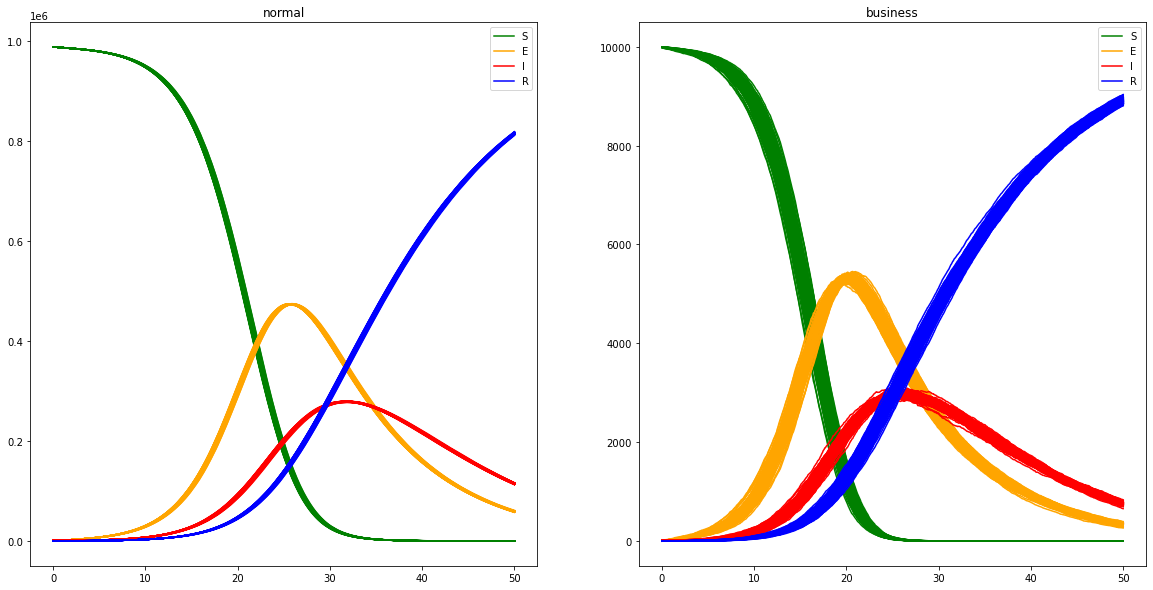

In [22]:
plot_compartment(data, test.times)